In [12]:
import os
import sys
import torch
import torch.nn as nn
import copy
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

# Figure out whether we have a GPU; if not use the CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [13]:
def plot_loss(history, ax=None, maxy=None, file=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epochs")
    loss = history[:,0]
    val_loss = history[:,1]
    if maxy:
        ax.set_ylim(0,maxy)
    else:
        ax.set_ylim(0,torch.max(val_loss))
    ax.spines['top'].set_visible(False)    # turns off the top "spine" completely
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)
    ax.plot(loss, label='train_loss')
    ax.plot(val_loss, label='val_loss')
    ax.legend(loc='lower right')
    plt.tight_layout()
    if file:
#         plt.savefig(f"/Users/{os.environ['USER']}/Desktop/{file}.pdf")
        plt.savefig(f"{os.environ['HOME']}/{file}.pdf")
        
def plot_accur(history, ax=None, file=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Epochs")
    accur = history[:,2]
    val_accur = history[:,3]
    ax.set_ylim(0,1.05)
    ax.plot(accur, label='accur')
    ax.plot(val_accur, label='val_accur')
    ax.spines['top'].set_visible(False)    # turns off the top "spine" completely
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)
    ax.legend(loc='lower right')
    plt.tight_layout()
    if file:
#         plt.savefig(f"/Users/{os.environ['USER']}/Desktop/{file}.pdf")
        plt.savefig(f"{os.environ['HOME']}/{file}.pdf")
        
def imgrid(images, digits, dim=(5,5), figsize=(4, 4)):
    fig, axes = plt.subplots(*dim, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        img_as_row = images[i]
        img28x28 = img_as_row.reshape(28,28)
        ax.axis('off') # don't show x, y axes
        ax.imshow(img28x28, cmap='Greys')
        ax.text(0, 8, digits[i], color='#313695', fontsize=15)

# Load Data


In [14]:
df_mnist = pd.read_csv("https://mlbook.explained.ai/data/mnist-10k-sample.csv.zip")
X = df_mnist.drop('digit', axis=1).values # get just pixels
y = df_mnist['digit'].values              # get just digit value

In [15]:

X.shape

(10000, 784)

In [16]:
# shuffle
n = len(X)
idx = np.random.randint(0,n,n)
X = X[idx,:]
y = y[idx]

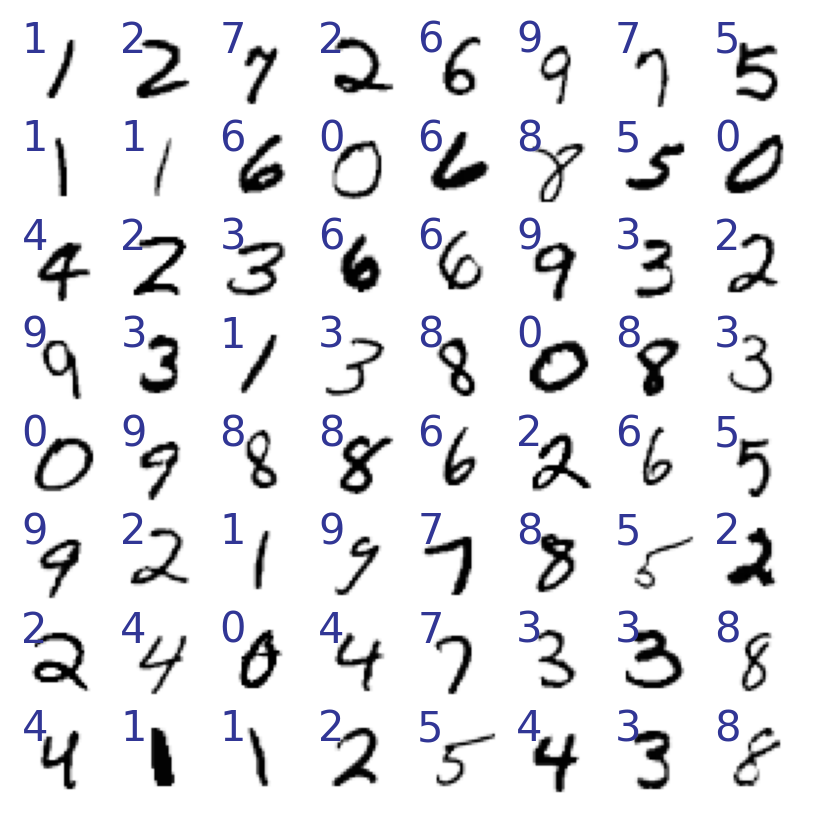

In [17]:
imgrid(X,digits=y,dim=(8,8),figsize=(5,5))

In [18]:
X = torch.tensor(X).float().to(device)
y = torch.tensor(y).to(device)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Training loop with SGD




In [19]:
def sgdtrain(model, X_train, y_train, X_test, y_test, 
             learning_rate = .0001, nepochs=2000, batch_size=32):
    n = len(X_train)
    nbatches = n // batch_size
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    history = []
    best_loss = 1e10
    best_model = None
    best_epoch = -1
    for epoch in range(nepochs+1):
        epoch_training_loss = 0.0
        # Must shuffle before each epoch
        shuffle_idx = torch.randperm(len(X_train))
        X_train_shuffled = X_train[shuffle_idx]
        y_train_shuffled = y_train[shuffle_idx]
        for p in range(0, n, batch_size):  # do one epoch
            # extract a batch at index p
            batch_X = X_train_shuffled[p:p+batch_size]
            batch_y = y_train_shuffled[p:p+batch_size]
            y_pred = model(batch_X)
            # Assume model yields softmax probabilities
            loss = F.cross_entropy(y_pred, batch_y)
            epoch_training_loss += loss.detach().item()

            optimizer.zero_grad()
            loss.backward() # autograd computes w1.grad, b1.grad, ...
            optimizer.step()

        epoch_training_loss /= nbatches # average batch loss

        # Computing metrics in a no_grad() block is for memory efficiency and speed;
        # means to avoid doing any of the auto gradient computations
        with torch.no_grad():
            y_pred = model(X_train)
            y_pred = torch.argmax(y_pred, axis=1)
            ncorrect = torch.sum(y_pred==y_train)
            accur = ncorrect.float() / len(y_train)

            y_test_pred = model(X_test)
            loss_test = F.cross_entropy(y_test_pred, y_test)
            y_test_pred = torch.argmax(y_test_pred, axis=1)
            ncorrect = torch.sum(y_test_pred==y_test)
            loss_accur = ncorrect.float() / len(y_test)
        
        # Save all of the computations; loss.item() detaches
        # the hidden auto gradient computation graph.
        # Gets just the value. Otherwise, this procedure
        # runs out of memory on the GPU. 
        history.append((loss.item(), loss_test, accur, loss_accur))
        if loss_test < best_loss:
            best_loss = loss_test
            best_model = copy.deepcopy(model)
            best_epoch = epoch
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} cross entropy loss {loss:7.4f}   test loss {loss_test:7.4f}")

    print(f"BEST test cross entropy loss {best_loss:.3f} at epoch {best_epoch}")
    return torch.tensor(history), best_model

a) Train with Batch SGD: 

Here we built a model with single layer of 50 neurons network and apply SGD to the whole batch of data. We used Pytorch library in building our network.



In [20]:
model = nn.Sequential(
    nn.Linear(784, 50),
    nn.ReLU(),
    nn.Linear(50, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
)

model = model.to(device) # make sure the model runs on the GPU as well

In [21]:
%%time
# On a CPU, this takes about 40 seconds but only 4 seconds on a GPU at colab.
# It only took 20 seconds to do the batch version of this in the previous notebook
# because we are doing more work in this version of the training loop.
history,_ = sgdtrain(model, X_train, y_train, X_test, y_test,
                     learning_rate = .03, nepochs=1000,
                     batch_size=len(X_train) # perform batch not mini-batch gradient descent
                  )

Epoch    0 cross entropy loss  2.3016   test loss  2.1671
Epoch  100 cross entropy loss  1.4883   test loss  1.5095
Epoch  200 cross entropy loss  1.4813   test loss  1.5034
Epoch  300 cross entropy loss  1.4799   test loss  1.5007
Epoch  400 cross entropy loss  1.4795   test loss  1.5009
Epoch  500 cross entropy loss  1.4788   test loss  1.5004
Epoch  600 cross entropy loss  1.4780   test loss  1.4994
Epoch  700 cross entropy loss  1.4779   test loss  1.4989
Epoch  800 cross entropy loss  1.4779   test loss  1.4993
Epoch  900 cross entropy loss  1.4776   test loss  1.4992
Epoch 1000 cross entropy loss  1.4775   test loss  1.4992
BEST test cross entropy loss 1.499 at epoch 698
CPU times: user 1min 11s, sys: 1.4 s, total: 1min 13s
Wall time: 1min 20s


In [22]:
y_pred = model(X_train)
y_pred = torch.argmax(y_pred, axis=1)
ncorrect = torch.sum(y_pred==y_train)
train_accur = ncorrect.float() / len(y_train)
print(f"Training accuracy {train_accur:.3f}")

Training accuracy 0.983


In [23]:
y_test_pred = model(X_test)
y_test_pred = torch.argmax(y_test_pred, axis=1)
ncorrect = torch.sum(y_test_pred==y_test)
test_accur = ncorrect.float() / len(y_test)
print(f"Validation accuracy {test_accur:.3f}")

Validation accuracy 0.961


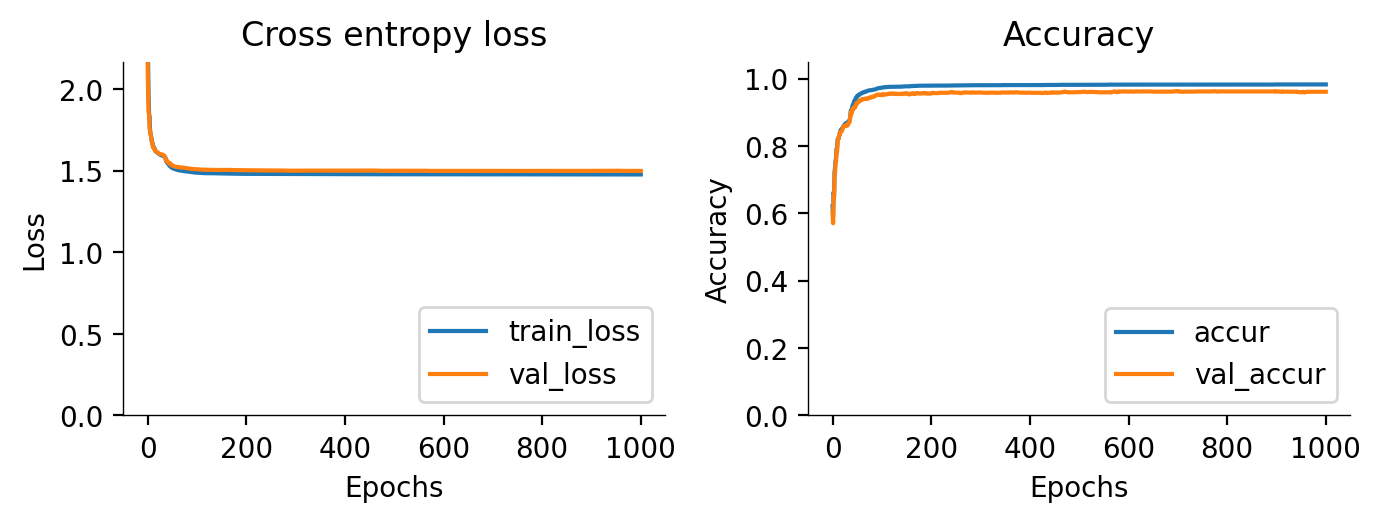

In [24]:
fig, axes = plt.subplots(1,2, figsize=(7,2.5))
plot_loss(history, ax=axes[0])
plot_accur(history, ax=axes[1])
axes[0].set_title("Cross entropy loss")
axes[1].set_title("Accuracy")
plt.show()

b) Mini batch and gradient descent


In [25]:
model = nn.Sequential(
    nn.Linear(784, 50),
    nn.ReLU(),
    nn.Linear(50, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
)

model = model.to(device) # make sure the model runs on the GPU as well

# Mini-batching dramatically slows down the process compared to batch gradient descent
# because the GPU can only operate on small chunks of data at once, rather than one
# big matrix during batch gradient descent.

history,_ = sgdtrain(model, X_train, y_train, X_test, y_test,
                     learning_rate = .001, # small learning rate due to imprecise gradients
                     nepochs=50,           # very few iterations for speed
                     batch_size=8          # very small batch size
                  )

Epoch    0 cross entropy loss  1.6232   test loss  1.5803
Epoch    5 cross entropy loss  1.5016   test loss  1.5155
Epoch   10 cross entropy loss  1.6423   test loss  1.5044
Epoch   15 cross entropy loss  1.4612   test loss  1.5025
Epoch   20 cross entropy loss  1.4613   test loss  1.4980
Epoch   25 cross entropy loss  1.4616   test loss  1.5013
Epoch   30 cross entropy loss  1.4613   test loss  1.4951
Epoch   35 cross entropy loss  1.4633   test loss  1.5005
Epoch   40 cross entropy loss  1.4612   test loss  1.4965
Epoch   45 cross entropy loss  1.4612   test loss  1.4962
Epoch   50 cross entropy loss  1.4612   test loss  1.4966
BEST test cross entropy loss 1.494 at epoch 48


In [26]:
y_pred = model(X_train)
y_pred = torch.argmax(y_pred, axis=1)
ncorrect = torch.sum(y_pred==y_train)
train_accur = ncorrect.float() / len(y_train)
print(f"Training accuracy {train_accur:.3f}")

Training accuracy 0.987


In [27]:
y_test_pred = model(X_test)
y_test_pred = torch.argmax(y_test_pred, axis=1)
ncorrect = torch.sum(y_test_pred==y_test)
test_accur = ncorrect.float() / len(y_test)
print(f"Validation accuracy {test_accur:.3f}")

Validation accuracy 0.965


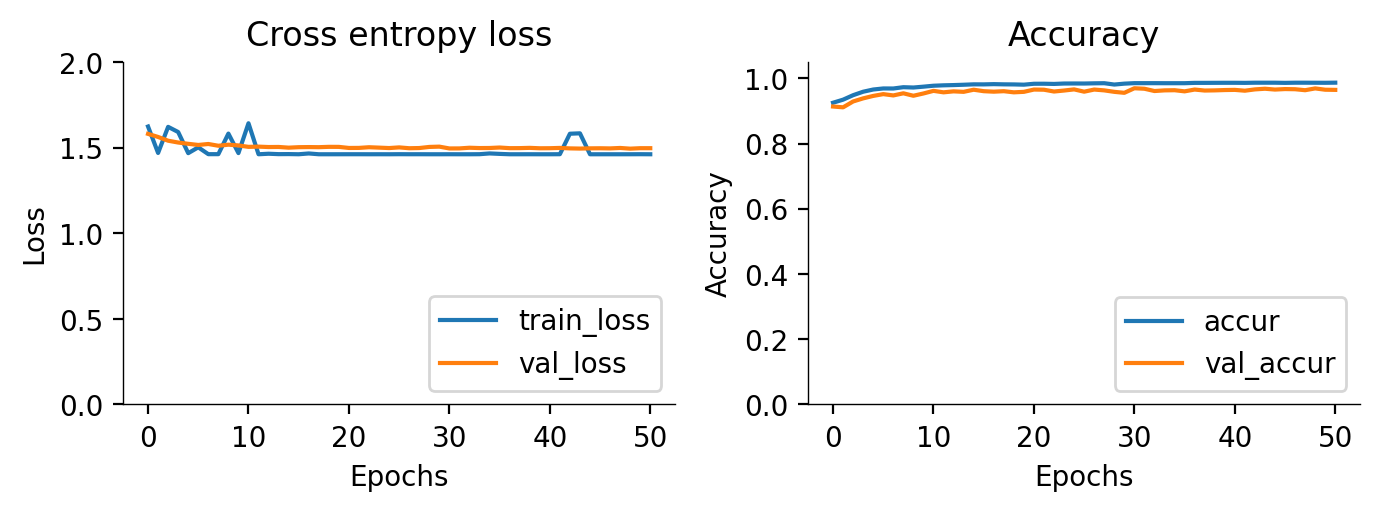

In [28]:
fig, axes = plt.subplots(1,2, figsize=(7,2.5))
plot_loss(history, ax=axes[0], maxy=2)
plot_accur(history, ax=axes[1])
axes[0].set_title("Cross entropy loss")
axes[1].set_title("Accuracy")
plt.show()